In [1]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import math
import string

import gensim
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn import init
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
from sklearn.cluster import MiniBatchKMeans
from sklearn import preprocessing

%matplotlib inline

### Data Vectorization classes

In [2]:
class Vocabulary(object):
    """ Class to process text and extract vocabulary for mapping
    
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            mask_token (str): the MASK token to add into the Vocabulary; indicates
                a position that will not be used in updating the model's parameters
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary

    """
    def __init__(self, token_to_idx=None, mask_token="<MASK>", unk_token="<UNK>", num_token='<NUM>'):
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}

        self._unk_token = unk_token
        self._mask_token = mask_token
        self._num_token = num_token
        
        self.unk_index = self.add_token(unk_token) 
        self.num_index = self.add_token(num_token)
        self.mask_index = self.add_token(self._mask_token)
        
    def to_serializable(self):
        """Returns a dictionary that can be serialized"""
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token, 
                'mask_token': self._mask_token,
                'num_token': self._num_token,
               }

    @classmethod
    def from_serializable(cls, contents):
        """Instantiates the Vocabulary from a serialized dictionary"""
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token

        Args:
            token (str): the item to add into the Vocabulary

        Returns:
            index (int): the integer corresponding to the token

        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token

        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens

        Returns:
            indices (list): a list of indices corresponding to the tokens

        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token or the UNK index if token isn't present
        
        Args:
            token (str): the token to look up 

        Returns:
            index (int): the index corresponding to the token

        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) for the UNK functionality 

        """
        if self.is_number(token):
            return self.num_index
            
        return self._token_to_idx.get(token, self.unk_index)
    
    def is_number(self, token):
        """Returns true if token in number else false"""
        num_regex = re.compile('^[+-]?[0-9]+\.?[0-9]*$')

        return bool(num_regex.match(token))

    def lookup_index(self, index):
        """Token associated with the index
        
        Args: 
            index (int): the index to look up

        Returns:
            token (str): the token corresponding to the index

        Raises:
            KeyError: if the index is not in the Vocabulary

        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [3]:
class Vectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use
    
        Args:
            vocab (Vocabulary): maps words to integers

    """    
    def __init__(self, vocab):
        self.vocab = vocab

    def vectorize(self, context, vector_length=-1):
        """Vectorizer

        Args:
            context (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector

        """

        indices = [self.vocab.lookup_token(token) for token in context.split(' ')]
        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[-len(indices):] = indices
        out_vector[:-len(indices)] = self.vocab.mask_index

        return out_vector
    
    @classmethod
    def from_dataframe(cls, df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            df(pandas.DataFrame): the target dataset

        Returns:
            an instance of the Vectorizer

        """
        vocab = Vocabulary()
        for index, row in df.iterrows():
            for token in row.context.split(' '):
                vocab.add_token(token)
            vocab.add_token(row.target)
            
        return cls(vocab)

    @classmethod
    def from_serializable(cls, contents):
        vocab = Vocabulary.from_serializable(contents['vocab'])
        return cls(vocab=vocab)

    def to_serializable(self):
        return {'vocab': self.vocab.to_serializable()}

### The Dataset

In [4]:
class Dataset(Dataset):
    """ Dataset reader

        Args:
            df(pandas.DataFrame): the dataset
            vectorizer (Vectorizer): vectorizer instatiated from dataset

    """
    def __init__(self, train_df, test_df, vectorizer):

        self.train_df = train_df
        self.train_size = len(train_df)
        
        self.test_df = test_df
        self.test_size = len(test_df)
        
        self._vectorizer = vectorizer
        
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, train_df.sentence))
        
        self._lookup_dict = {
            'train': (self.train_df, self.train_size),
            'test': (self.test_df, self.test_size)
        }
        
        self.set_split('train')
        
    @property
    def max_seq_length(self):
        """Max dataset sequence len"""
        return self._max_seq_length

    def set_split(self, split="train"):
        """Selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]
    
    def get_vectorizer(self):
        """Returns the vectorizer"""
        return self._vectorizer

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """Primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 

        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)

        """
        row = self._target_df.iloc[index]
        target = 0.

        context_vector = self._vectorizer.vectorize(row.sentence, self._max_seq_length)

        return {
            'x_data': context_vector,
            'y_target': 0. if self._target_split == 'train' else row.label,
        }

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)

        Returns:
            number of batches in the dataset

        """
        return len(self) // batch_size
    

### Utils

In [5]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """A generator function which wraps the PyTorch DataLoader. It will ensure 
        each tensor is on the write device location
        
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device) \
            if isinstance(data_dict[name], torch.Tensor) else data_dict[name]
        yield out_data_dict

In [6]:
def preprocess_text(text):
    """Text preprocessing regular expression"""
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [7]:
def get_centroids(w2v_model, aspects_count):
    """Clustering all word vectors with K-means and returning L2-normalizes
        cluster centroids; used for aspects matrix initialization
    """
    km = MiniBatchKMeans(n_clusters=aspects_count, verbose=0, n_init=100)
    m = []

    for k in w2v_model.wv.vocab:
        m.append(w2v_model.wv[k])

    m = np.matrix(m)

    km.fit(m)
    clusters = km.cluster_centers_

    # L2 normalization
    norm_aspect_matrix = clusters / np.linalg.norm(clusters, axis=-1, keepdims=True)

    return norm_aspect_matrix

In [8]:
def calculate_conv_output(input_, kernel, padding, stride):
    """Calculate the output size in Convolution layer"""
    return math.floor(((input_ - kernel + 2 * padding) / stride) + 1)

### The model: CBAE(Capsule Based Aspect Extraction)

In [9]:
class ConvLayer(nn.Module):
    """ N-gram convolutional layer
    
        Args:
            in_channels: convolutional input channels
            out_channels: convolutional output channels
            kernel_size: convolutional kernel size
            stride: convolutional stride
    
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()

        self.convnet = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=kernel_size,
                stride=stride
            ),
            nn.ELU(),
        )

    def forward(self, x):
        return self.convnet(x)

In [10]:
class PrimaryCaps(nn.Module):
    """ Primary caps layer
    
        Args:
            num_capsules: capsules count
            in_channels: input channels
            out_channels: output channels
            kernel_size: capsule kernel size
            stride: capsule stride
            conv_out_size: tensor size from above layer

    """
    def __init__(self, num_capsules, in_channels, out_channels, kernel_size, stride, conv_out_size):
        super(PrimaryCaps, self).__init__()

        self.out_channels = out_channels
        self.capsules = nn.ModuleList([
            nn.Conv1d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=0
            ) 
            for _ in range(num_capsules)
        ])
        
        self._out_channels = out_channels
        self._conv_out_size = conv_out_size
    
    def forward(self, x):
        u = [capsule(x) for capsule in self.capsules]
        u = torch.stack(u, dim=1)
        u = u.view(x.size(0), self._out_channels * self._conv_out_size , -1)

        return self.squash(u)
    
    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm + 1e-07))

        return output_tensor

In [11]:
class SecondaryCaps(nn.Module):
    """ Secondary capsules layer
    
        Args:
            num_capsules: capsules count
            num_routes: routing iteration count
            in_channels: in channels dim
            out_channels: out channels dim
    
    """
    def __init__(self, num_capsules, num_routes, in_channels, out_channels):
        super(SecondaryCaps, self).__init__()

        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))

    def forward(self, x):
        batch_size = x.size(0)
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)

        W = torch.cat([self.W] * batch_size, dim=0)
        u_hat = torch.matmul(W, x)

        b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1)).to(args.device)

        num_iterations = 3
        for iteration in range(num_iterations):
            c_ij = F.softmax(b_ij, dim=2)

            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)

            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
            v_j = self.squash(s_j)
            
            if iteration < num_iterations - 1:
                a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
                b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)

        return v_j.squeeze(1)
    
    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm + 1e-07))

        return output_tensor

In [12]:
class CapsNet(nn.Module):
    """ Caps net module of CBAE
    
        Args:
            conv_out_ch: N-gram convolutional out channels
            conv_kernel: N-gram convolutional kernel size
            conv_stride: N-gram convolutional stride
            prime_num_capsules: Primary capsules count
            prime_out_ch: Primary capsules out channels
            prime_kernel: Primary capsules kernel size
            prime_stride: Primary capsules stride
            secondary_num_capsules: Secondary capsules count
            secondary_out_channels=Secondary capsules out channels
            maxlen: sentence max length taken into account
    
    """
    def __init__(
        self,
        conv_in_ch,
        conv_out_ch,
        conv_kernel,
        conv_stride,
        prime_num_capsules,
        prime_out_ch,
        prime_kernel,
        prime_stride,
        secondary_num_capsules,
        secondary_out_channels,
        input_len,
    ):
        super(CapsNet, self).__init__()
        self._secondary_out_size=secondary_out_channels * secondary_num_capsules
        
        self.conv_layer = ConvLayer(
            in_channels=conv_in_ch,
            out_channels=conv_out_ch,
            kernel_size=conv_kernel,
            stride=conv_stride,
        )
        conv_layer_output = calculate_conv_output(
            input_=input_len, 
            kernel=conv_kernel, 
            padding=0, 
            stride=conv_stride,
        )
        
        prime_caps_conv_output = calculate_conv_output(
            input_=conv_layer_output, 
            kernel=prime_kernel, 
            padding=0, 
            stride=prime_stride,
        )
        
        self.primary_caps = PrimaryCaps(
            num_capsules=prime_num_capsules, 
            in_channels=conv_out_ch, 
            out_channels=prime_out_ch, 
            kernel_size=prime_kernel, 
            stride=prime_stride,
            conv_out_size=prime_caps_conv_output,
        )
        
        self.secondary_caps = SecondaryCaps(
            num_capsules=secondary_num_capsules,
            num_routes=prime_caps_conv_output * prime_out_ch,
            in_channels=prime_num_capsules,
            out_channels=secondary_out_channels,
        )

        self.fc = nn.Linear(secondary_out_channels * secondary_num_capsules, input_len)
        self.tanh = nn.Tanh()
        self.capsule_softmax = torch.nn.Softmax(dim=1)

    def forward(self, data):
        output = self.secondary_caps(self.primary_caps(self.conv_layer(data)))
        output = output.reshape(-1, self._secondary_out_size)
        output = F.relu(output)
        output = self.fc(output)
        return self.capsule_softmax(self.tanh(output))

In [13]:
class CBAE(torch.nn.Module):
    """ Capsule Based Aspect Extraction
        
        Args:
            wv_dim: word vector size
            asp_count: number of aspects
            ortho_reg: coefficient for tuning the ortho-regularizer's influence
            maxlen: sentence max length taken into account
            init_aspects_matrix: None or init. matrix for aspects
            pretrained_embedding: w2v vectors
            padding_index: Mask index
            cn_conv_out_ch: N-gram convolutional out channels
            cn_conv_kernel: N-gram convolutional kernel size
            cn_conv_stride: N-gram convolutional stride
            cn_prime_num_capsules: Primary capsules count
            cn_prime_out_ch: Primary capsules out channels
            cn_prime_kernel: Primary capsules kernel size
            cn_prime_stride: Primary capsules stride
            cn_secondary_num_capsules: Secondary capsules count
            cn_secondary_out_channels=Secondary capsules out channels
            encoder_only: bool - return output after encoding

    """
    def __init__(
        self, 
        wv_dim, 
        asp_count,
        maxlen, 
        init_aspects_matrix,
        pretrained_embedding,
        padding_index,
        cn_conv_out_ch,
        cn_conv_kernel,
        cn_conv_stride,
        cn_prime_num_capsules,
        cn_prime_out_ch,
        cn_prime_kernel,
        cn_prime_stride,
        cn_secondary_num_capsules,
        cn_secondary_out_channels,
        encoder_only=False,
    ):
        super(CBAE, self).__init__()
        self.wv_dim = wv_dim
        self.asp_count = asp_count
        self.maxlen = maxlen

        self.embedding = torch.nn.Embedding.from_pretrained(
            torch.FloatTensor(pretrained_embedding), 
            padding_idx=padding_index,
        )
        
        self.caps_net = CapsNet(
            conv_in_ch=wv_dim,
            conv_out_ch=cn_conv_out_ch,
            conv_kernel=cn_conv_kernel,
            conv_stride=cn_conv_stride,
            prime_num_capsules=cn_prime_num_capsules,
            prime_out_ch=cn_prime_out_ch,
            prime_kernel=cn_prime_kernel,
            prime_stride=cn_prime_stride,
            secondary_num_capsules=cn_secondary_num_capsules,
            secondary_out_channels=cn_secondary_out_channels,
            input_len=maxlen,
        )

        self.linear_transform = torch.nn.Linear(self.wv_dim, self.asp_count)
        self.softmax_aspects = torch.nn.Softmax(dim=1)
        self.aspects_embeddings = Parameter(torch.empty(size=(wv_dim, asp_count)))

        if init_aspects_matrix is None:
            torch.nn.init.xavier_uniform(self.aspects_embeddings)
        else:
            self.aspects_embeddings.data = torch.from_numpy(init_aspects_matrix.T)
            
        self.encoder_only = encoder_only

    def get_aspects_importances(self, text_embeddings):
        """Get aspect importances
        
        Args:
            text_embedding: embeddings of a sentence as input
        
        Returns: 
            capsule weights, aspects_importances, weighted_text_emb

        """
        # compute capsule scores, looking at text embeddings average
        caps_weights = self.caps_net(text_embeddings.permute(0, 2, 1))

        # multiplying text embeddings by attention scores -- and summing
        # (matmul: we sum every word embedding's coordinate with attention weights)
        weighted_text_emb = torch.matmul(caps_weights.unsqueeze(1),  # (batch, 1, sentence)
                                         text_embeddings  # (batch, sentence, wv_dim)
                                         ).squeeze()

        # encoding with a simple feed-forward layer (wv_dim) -> (aspects_count)
        raw_importances = self.linear_transform(weighted_text_emb)

        # computing 'aspects distribution in a sentence'
        aspects_importances = self.softmax_aspects(raw_importances)

        return caps_weights, aspects_importances, weighted_text_emb

    def forward(self, text_embeddings, negative_samples_texts):
        
        text_embeddings = self.embedding(text_embeddings)

        # encoding: words embeddings -> sentence embedding, aspects importances
        _, aspects_importances, weighted_text_emb = self.get_aspects_importances(text_embeddings)
        
        if self.encoder_only:
            return aspects_importances
        else:
            negative_samples_texts = self.embedding(negative_samples_texts)
            
            # negative samples are averaged
            averaged_negative_samples = torch.mean(negative_samples_texts, dim=1)
            averaged_negative_samples = torch.mean(averaged_negative_samples, dim=1)
            
            # decoding: aspects embeddings matrix, aspects_importances -> recovered sentence embedding
            recovered_emb = torch.matmul(self.aspects_embeddings, aspects_importances.unsqueeze(2)).squeeze()
            
            return weighted_text_emb, recovered_emb, averaged_negative_samples

    def get_aspect_words(self, w2v_model, topn=10):
        """Getting aspects words"""
        words = []
        aspects = self.aspects_embeddings.cpu().detach().numpy()
        words_scores = w2v_model.wv.vectors.dot(aspects)

        for row in range(aspects.shape[1]):
            argmax_scalar_products = np.argsort(- words_scores[:, row])[:topn]
            words.append([w2v_model.wv.index2word[i] for i in argmax_scalar_products])

        return words

### Training utils

In [14]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

        
def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

    
def make_train_state(args):
    return {
        'stop_early': False,
        'early_stopping_step': 0,
        'early_stopping_best_val': 1e8,
        'learning_rate': args.learning_rate,
        'epoch_index': 0,
        'train_loss': [],
        'model_filename': args.model_state_file
    }


def update_train_state(args, model, train_state):
    """Handle the training state updates

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    Args:
        args: main arguments
        model: model to train
        train_state: a dictionary representing the training state values
    
    Returns:
        new train_state

    """
    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['train_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

### Settings

In [15]:
args = Namespace(
    train_data='preprocessed_data/restaurant/train.txt',
    test_data='preprocessed_data/restaurant/test.txt',
    test_labels='preprocessed_data/restaurant/test_label.txt',
    emb_path='preprocessed_data/restaurant/w2v_embedding',
    
    emb_dim=200,
    batch_size=50,
    vocab_size=9000,
    aspect_size=14,
    epochs=10,
    neg_size=20,
    maxlen=-1,

    cn_conv_out_channels = 200,
    cn_conv_kernel = 3,
    cn_conv_stride = 1,
    cn_prime_num_capsules=7,
    cn_prime_kernel=3,
    cn_prime_out_channels=32,
    cn_prime_stride=1,
    cn_secondary_num_capsules=7,
    cn_secondary_out_channels=32,

    cuda=True,
    reload_from_files=False,
    learning_rate=1e-3,
    early_stopping_criteria=5,  
    catch_keyboard_interrupt=True,
    seed=1234,
    
    save_dir="model_storage",
    model_state_file="model.pth",
)

args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))
set_seed_everywhere(args.seed, args.cuda)
handle_dirs(args.save_dir)

Using CUDA: True


### Data preprocessings

In [16]:
sentences = []
with open('preprocessed_data/restaurant/train.txt') as fp:
    for line in tqdm(fp.readlines()):
        sentences.append(line)
        
cleaned_sentences = [preprocess_text(sentence) for sentence in sentences]

print (len(cleaned_sentences), "sentences")
print ("Sample:", cleaned_sentences[42])

train_df = pd.DataFrame(cleaned_sentences, columns=["sentence"])

train_df.head()


279885 sentences
Sample: place fancy wouldn go date 


,sentence
0,like jeollado like roll sometimes price variet...
1,like roll tiny order anyway often get order wr...
2,money dependable fun place get sushi bring fri...
3,place great deal price food give
4,crab roll made real crab imitation crab


In [17]:
sentences = []
labels = []

with open('preprocessed_data/restaurant/test.txt') as fp:
    for line in tqdm(fp.readlines()):
        sentences.append(line)
        
with open('preprocessed_data/restaurant/test_label.txt') as fp:
    for line in tqdm(fp.readlines()):
        labels.append(line)
        
cleaned_sentences = [preprocess_text(sentence) for sentence in sentences]
cleaned_labels = [preprocess_text(label.split()[0]) for label in labels]

print (len(cleaned_sentences), "sentences")
print ("Sample sentence:", cleaned_sentences[42])
print ("Sample label:", cleaned_labels[42])
    
test_df = pd.DataFrame({'sentence': cleaned_sentences, 'label': cleaned_labels})

test_df.head()


1490 sentences
Sample sentence: food prepared quickly efficiently 
Sample label: food


,sentence,label
0,staff friendliest competent stickler service e...,staff
1,great group great date great early brunch nigh...,ambience
2,like cafe noir dont get wrong jsut people work...,staff
3,service terrible wait everything ask several d...,staff
4,waitress seems concerned looking good actually...,staff


In [18]:
w2v = gensim.models.Word2Vec.load(args.emb_path)
token2index_lim = {token: index for index, token in enumerate(w2v.wv.index2word) if index < args.vocab_size}
token2index_all = {token: index for index, token in enumerate(w2v.wv.index2word)}
vocab = Vocabulary(token2index_lim)
vectorizer = Vectorizer(vocab)
dataset = Dataset(train_df, test_df , vectorizer)

### Training routine

In [19]:
model = CBAE(
    wv_dim=args.emb_dim,
    asp_count=args.aspect_size,
    maxlen=dataset.max_seq_length, 
    init_aspects_matrix=get_centroids(w2v, args.aspect_size),
    pretrained_embedding=w2v.wv.vectors,
    padding_index=vocab.mask_index,
    cn_conv_out_ch=args.cn_conv_out_channels,
    cn_conv_kernel=args.cn_conv_kernel,
    cn_conv_stride=args.cn_conv_stride,
    cn_prime_num_capsules=args.cn_prime_num_capsules,
    cn_prime_out_ch=args.cn_prime_out_channels,
    cn_prime_kernel=args.cn_prime_kernel,
    cn_prime_stride=args.cn_prime_stride,
    cn_secondary_num_capsules=args.cn_secondary_num_capsules,
    cn_secondary_out_channels=args.cn_secondary_out_channels,
)

model = model.to(args.device)
loss_func = nn.TripletMarginLoss(margin=1, swap=False, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min', 
    factor=0.5,
    patience=1
)

train_state = make_train_state(args)

In [20]:
epoch_bar = tqdm(
    desc='training routine', 
    total=args.epochs,
    position=1,
)

dataset.set_split('train')
train_bar = tqdm(
    desc='train',
    total=dataset.get_num_batches(args.batch_size), 
    position=1, 
)

for epoch_index in range(args.epochs):
    
    train_state['epoch_index'] = epoch_index
    
    running_loss = 0.0
    model.train()
    
    batch_generator = generate_batches(
        dataset, 
        batch_size=args.batch_size, 
        device=args.device
    )
    
    neg_batch_generator = generate_batches(
        dataset, 
        batch_size=args.batch_size, 
        shuffle=False,
        device=args.device,
    )

    for batch_index, batch_dict in enumerate(batch_generator):

        optimizer.zero_grad()
        
        x = batch_dict['x_data']
        y = batch_dict['y_target'].float()
        x_neg = next(neg_batch_generator)['x_data']

        negative_samples = torch.stack(
            tuple([x_neg[torch.randperm(x_neg.shape[0])[:args.neg_size]] 
                   for _ in range(args.batch_size)])
        ).to(args.device)

        anchor, positive, negative = model(x, negative_samples)
        loss = loss_func(anchor, positive, negative)
        loss_t = loss.item()

        running_loss += (loss_t - running_loss) / (batch_index + 1)
        loss.backward()

        optimizer.step()
        
        train_bar.set_postfix(loss=running_loss, epoch=epoch_index)
        train_bar.update()

    train_state['train_loss'].append(running_loss)
    train_state = update_train_state(args=args, model=model, train_state=train_state)
    scheduler.step(train_state['train_loss'][-1])
    
    # uncomment the lines below to display the aspects words after each training loop
    # print(batch_index, "batches, and LR:", optimizer.param_groups[0]['lr'])
    # for i, aspect in enumerate(model.get_aspect_words(w2v)):
    #     print(i, " ".join([a for a in aspect]))
    # print()

    if train_state['stop_early']:
        break

    train_bar.n = 0

    epoch_bar.set_postfix(best_val=train_state['early_stopping_best_val'])
    epoch_bar.update()

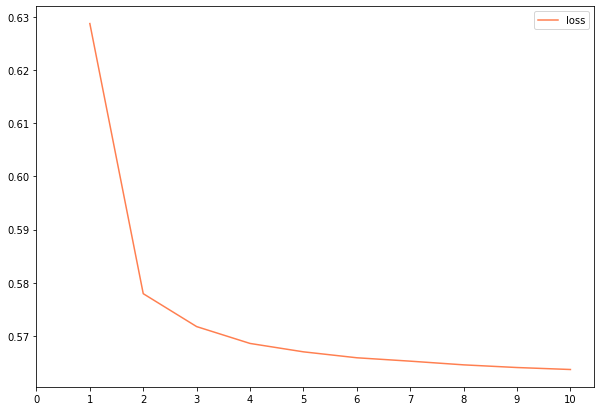

In [21]:
plt.figure(figsize=(10, 7))
sns.lineplot(
    x=[epoch + 1 for epoch in range(len(train_state['train_loss']))],
    y=train_state['train_loss'],
    color='coral', 
    label='loss',
)

plt.xticks([epoch for epoch in range(len(train_state['train_loss']) + 1)])
plt.show()

### Evaluation

In [22]:
model.load_state_dict(torch.load(train_state['model_filename']))
model = model.to(args.device)
loss_func = torch.nn.MSELoss(reduction="sum")
dataset.set_split('test')

batch_generator = generate_batches(
    dataset, 
    batch_size=args.batch_size, 
    device=args.device,
    drop_last=False
)

model.eval()
model.encoder_only = True
predictions = []
targets = []

with torch.no_grad():
    for batch_index, batch_dict in enumerate(batch_generator):
        
        x = batch_dict['x_data']
        y_target = batch_dict['y_target']
        
        y_pred = model(x, None)
        for pred, target in zip(y_pred, y_target):
            predictions.append(pred.cpu().numpy().argmax())
            targets.append(target)

In [23]:
print(len(predictions))
print(len(targets))
print(Counter(predictions))
print(Counter(targets))

1490
1490
Counter({0: 717, 3: 208, 4: 188, 8: 176, 13: 67, 5: 29, 10: 29, 2: 27, 9: 24, 7: 12, 6: 7, 12: 3, 11: 3})
Counter({'food': 887, 'staff': 352, 'ambience': 251})


In [33]:
for i, aspect in enumerate(model.get_aspect_words(w2v)):
    print(i, " ".join([a for a in aspect]))

0 chicken potato onion tomato sauce mushroom beef fried grilled bean
1 recommend tuna favorite best gras highly grilled seared roasted shrimp
2 pay money leave didn dont unless wouldn want order would
3 table u minute asked manager min seated waiter seat tip
4 wall room space ceiling lit lighting floor window wood booth
5 dish menu entree course flavor item plate ingredient prix portion
6 birthday went saturday reservation friend friday week night anniversary review
7 review year lived worst eaten ny experience life nyc ve
8 service staff waitstaff attentive friendly server courteous helpful rude professional
9 month time minute week hour year sit ago reservation waiting
10 great drink wine sangria nice perfect excellent good romantic amazing
11 gras crust rib pork foie tender creme filet priced tuna
12 cream wall chocolate butter fruit sauce sweet ice tomato lemon
13 joint chinese neighborhood japanese american cuisine fare mexican indian standard


In [32]:
# update cluster map manually after each training

# possible labels
LABELS = ['ambience', 'food', 'miscellaneous', 'price', 'staff', 'anecdotes']
cluster_map = {
    0: 'food', 
    1: 'food', 
    2: 'price', 
    3: 'staff',
    4: 'ambience', 
    5: 'food', 
    6: 'anecdotes',  
    7: 'miscellaneous', 
    8: 'staff', 
    9: 'miscellaneous', 
    10: 'food', 
    11: 'food', 
    12: 'food', 
    13: 'food'
}

y_pred = [cluster_map[pred] for pred in predictions]
y_true = targets

print(classification_report(y_true, y_pred))

               precision    recall  f1-score   support

     ambience       0.83      0.62      0.71       251
    anecdotes       0.00      0.00      0.00         0
         food       0.89      0.85      0.87       887
miscellaneous       0.00      0.00      0.00         0
        price       0.00      0.00      0.00         0
        staff       0.68      0.75      0.71       352

     accuracy                           0.79      1490
    macro avg       0.40      0.37      0.38      1490
 weighted avg       0.83      0.79      0.80      1490

